<div style="text-align:center">
    <h1>Implementing a recommendation engine like Amazon's</h1>
</div>
<div style="text-align:center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Amazon_logo.svg/320px-Amazon_logo.svg.png" alt="Amazon" />
</div>

# Importing

In [1]:
# Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.simplefilter('ignore')
from tabulate import tabulate

# Load the Dataset and Add headers
electronics_data = pd.read_csv("data/ratings_Electronics.csv", names = ['userId', 'productId','Rating','timestamp'])
electronics_data

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


# Data Preprocessing

Checking for missing values

In [2]:
print('Number of missing values across columns:', electronics_data.isnull().sum(), sep='\n')

Number of missing values across columns:
userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


Checking for duplicate rows

In [3]:
print('Number of duplicate rows:', electronics_data.duplicated().sum())

Number of duplicate rows: 0


Dropping the TimeStamp Column

In [4]:
electronics_data.drop(['timestamp'], axis=1, inplace=True)

# EDA

In [5]:
print(f"Dataset has {electronics_data.shape[0]} rows and {electronics_data.shape[1]} columns.")

Dataset has 7824482 rows and 3 columns.


In [6]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
display(electronics_data.describe()['Rating'].T.round(2))

print('\n\nMinimum rating is: %d' %(electronics_data['Rating'].min()))
print('Maximum rating is: %d' %(electronics_data['Rating'].max()))

count    7824482.00
mean           4.01
std            1.38
min            1.00
25%            3.00
50%            5.00
75%            5.00
max            5.00
Name: Rating, dtype: float64



Minimum rating is: 1
Maximum rating is: 5


In [8]:
pd.DataFrame([electronics_data.shape[0], electronics_data['userId'].nunique(), electronics_data['productId'].nunique()],
    index=["Total number of ratings", "Total number of unique Users", "Total number of unique Products"], columns=['Count'])

,Count
Total number of ratings,7824482
Total number of unique Users,4201696
Total number of unique Products,476002


`Important!` Since the dataset has no item features I cannot use content based filtering. For completely new users I will recommend them top 10 or 20 trending items based on popularity. For current users since number of products (476K) is less than number of users(4.2MM), so item-item collaborative filtering would make sense.

#### Ratings Per User

In [9]:
no_of_ratings_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_ratings_per_user.head(10)

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: Rating, dtype: int64

In [10]:
no_of_ratings_per_user.describe().round(2)

count    4201696.00
mean           1.86
std            2.89
min            1.00
25%            1.00
50%            1.00
75%            2.00
max          520.00
Name: Rating, dtype: float64

**Inference:** Looks like most people are providing ratings for 1 or 2 items.

In [11]:
print(f"Out of the total {len(no_of_ratings_per_user)} people who provided ratings, {sum(no_of_ratings_per_user >= 50)} are individuals who have rated more than 50 products.")

Out of the total 4201696 people who provided ratings, 1540 are individuals who have rated more than 50 products.


#### Ratings Per Product

In [12]:
no_of_ratings_per_product = electronics_data.groupby(by='productId')['Rating'].count().sort_values(ascending=False)
no_of_ratings_per_product.head(10)

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: Rating, dtype: int64

In [13]:
no_of_ratings_per_product.describe().round(2)

count    476002.00
mean         16.44
std         112.70
min           1.00
25%           1.00
50%           2.00
75%           7.00
max       18244.00
Name: Rating, dtype: float64

**Inference:** About half of the products have received 1 or 2 ratings. Average rating per product is 16 but this average is inflated due to right skewness of rating per product.

In [14]:
print(f"Out of the total {len(no_of_ratings_per_product)} products, only {sum(no_of_ratings_per_product >= 50)} products have received more than 50 ratings.")

Out of the total 476002 products, only 26226 products have received more than 50 ratings.


# Data Visualization

#### Distribution of the rating

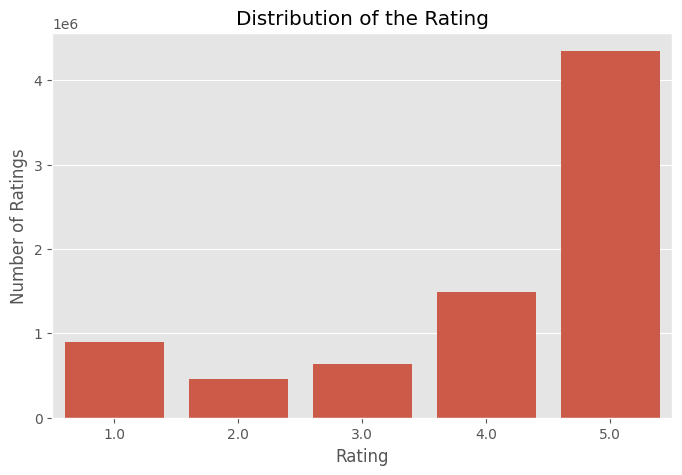

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 5))
sns.countplot(data=electronics_data, x='Rating')
plt.title("Distribution of the Rating")
plt.ylabel("Number of Ratings")
plt.show();

**Inference:** Looks like most of the people has given the rating of 5!

#### Ratings per user Distribution

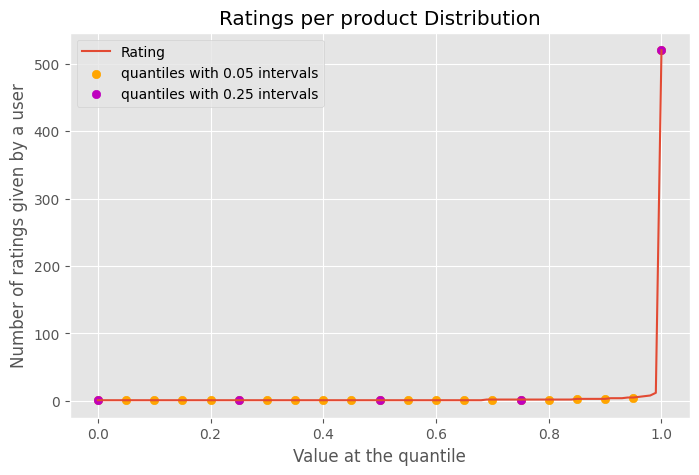

In [16]:
quantiles = no_of_ratings_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation='higher') 

plt.figure(figsize=(8, 5))

# Plot the quantiles as a line plot
quantiles.plot()

# Add scatter points for quantiles at 0.05 intervals
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# Add scatter points for quantiles at 0.25 intervals
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label="quantiles with 0.25 intervals")

plt.title("Ratings per product Distribution")
plt.ylabel('Number of ratings given by a user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show();

#### Ratings per product Distribution

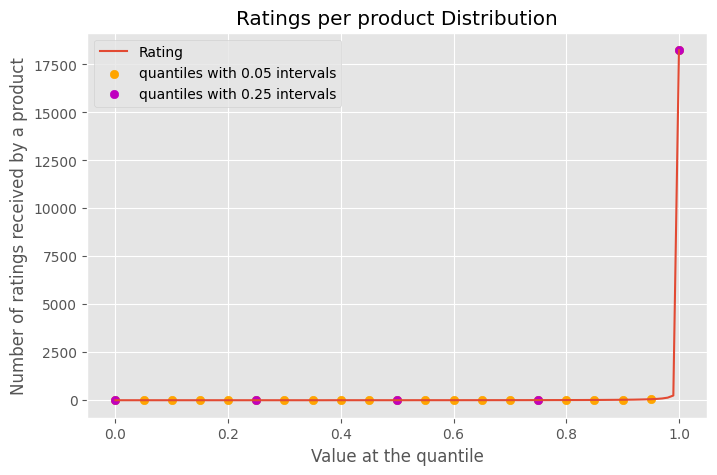

In [17]:
quantiles = no_of_ratings_per_product.quantile(np.arange(0, 1.01, 0.01), interpolation='higher') 

plt.figure(figsize=(8, 5))

# Plot the quantiles as a line plot
quantiles.plot()

# Add scatter points for quantiles at 0.05 intervals
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# Add scatter points for quantiles at 0.25 intervals
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label="quantiles with 0.25 intervals")

plt.title("Ratings per product Distribution")
plt.ylabel('Number of ratings received by a product')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show();

**Inference:** We can see that both `ratings per user` and `ratings per product` are heavily clustered at the top end of the quantile.

# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [18]:
# Product Ratings Approach: We set a threshold to consider products with minimum 50 ratings
# products_ratings_min50 = electronics_data.groupby("productId").filter(lambda x: x['Rating'].count() >= 50)
# popular_50 = pd.DataFrame({
#     "productId" : products_ratings_min50['productId'].unique(),
#     'total ratings': products_ratings_min50.groupby('productId')['Rating'].count(),
#     'mean rating': products_ratings_min50.groupby('productId')['Rating'].mean(),
# }).reset_index(drop=True)



# User Ratings Approach: We set a threshold to consider users who have rated more than 50 times
user_ratings_min50 = electronics_data.groupby("userId").filter(lambda x: x['Rating'].count() >= 50)

popular_50 = pd.DataFrame({
    "productId" : user_ratings_min50['productId'].unique(),
    'total ratings': user_ratings_min50.groupby('productId')['Rating'].count(),
    'mean rating': user_ratings_min50.groupby('productId')['Rating'].mean(),
}).reset_index(drop=True)

popular_50

,productId,total ratings,mean rating
0,0594451647,1,5.000000
1,0594481813,1,3.000000
2,0970407998,2,2.500000
3,0972683275,4,4.750000
4,1400501466,6,3.333333
...,...,...,...
48185,B00LED02VY,1,4.000000
48186,B00LGN7Y3G,1,5.000000
48187,B00LGQ6HL8,5,5.000000
48188,B00LI4ZZO8,2,4.500000


**NOTE**
<p>Active users are emphasized in collaborative filtering, where recommendations are based on user behavior and preferences. The idea is to identify users with a substantial number of ratings, as these users contribute more information to the collaborative filtering process and thereby build a robust model. Active users also provide more reliable signals for similarity between items for item-item collaborative filtering.</p>
<p>Active products are more relevant in content-based filtering, where recommendations are made by analyzing the features of items and suggesting similar ones.</p>

#### Top 10 products

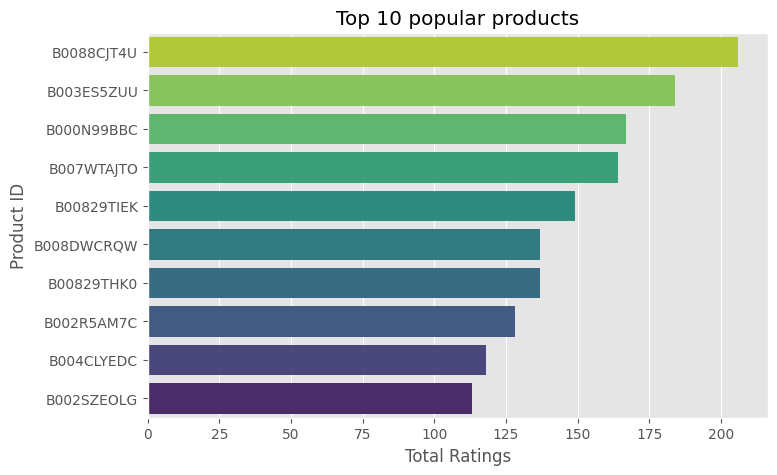

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(x='total ratings', y='productId', data=popular_50.sort_values(by='total ratings', ascending=False).head(10), palette='viridis_r')
plt.title('Top 10 popular products')
plt.xlabel('Total Ratings')
plt.ylabel('Product ID')
plt.show();

#### Distribution of ratings per product

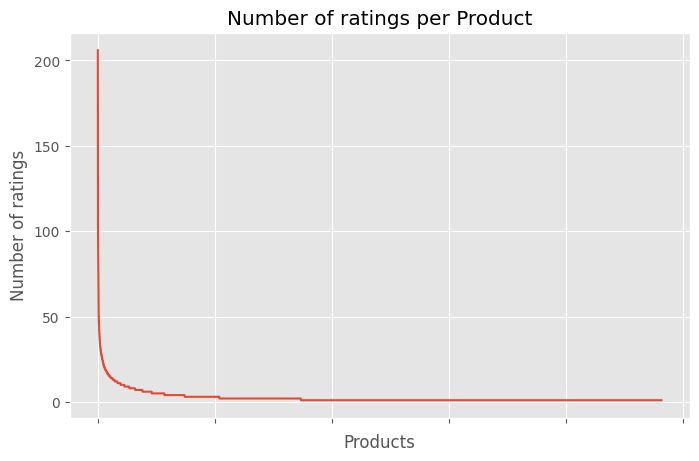

In [20]:
fig = plt.figure(figsize=[8, 5])
ax = plt.gca()

plt.plot(popular_50['total ratings'].sort_values(ascending=False).values)
plt.title('Number of ratings per Product')
plt.xlabel('Products')
plt.ylabel('Number of ratings')
ax.set_xticklabels([])   # Removes the x-axis tick labels
plt.show();

#### Distribution of mean ratings

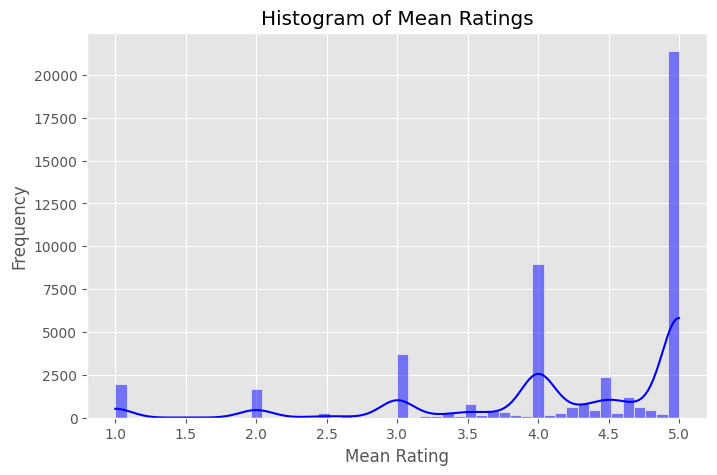

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(popular_50['mean rating'], bins=50, kde=True, color='blue')
plt.title('Histogram of Mean Ratings')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')
plt.show();

**Inference:** Average ratings of products are clusters at of the points 1, 2, 3, 4, 5. Look like the active users have consistently given high ratings of 5 to the majority of products!


#### Mean Rating vs Rating count

<Figure size 1000x800 with 0 Axes>

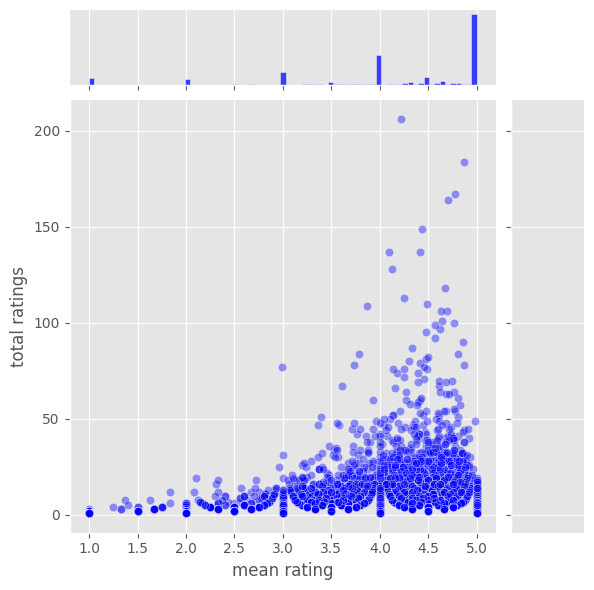

In [22]:
plt.figure(figsize=(10, 8))
sns.jointplot(x='mean rating', y='total ratings', data=popular_50, alpha=0.4, color='blue')
plt.show();

# Item-Based Collaborative Filtering

In [23]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

# Reading the dataset
reader = Reader(rating_scale=(1, 5))   # ratings are on a scale from 1 to 5
data = Dataset.load_from_df(user_ratings_min50, reader)

trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

# k-NN collaborative filtering algorithm with means
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False}) # for item-based filtering
algo.fit(trainset)

test_pred = algo.test(testset)
test_pred[:5]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid='A294BKN913UOGP', iid='B0002E3WKO', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ANTN61S4L7WG9', iid='B00HFAEBWG', r_ui=5.0, est=4.162691459046874, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='AROQO2VDODT7', iid='B001G9TYHE', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2YYHSORXIHZCS', iid='B000AMLU1Q', r_ui=3.0, est=4.261789374524737, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AYNAH993VDECT', iid='B00CPIF4G0', r_ui=4.0, est=4.0, details={'actual_k': 0, 'was_impossible': False})]

**Conclusion**
<br>
The test_pred variable contains predictions generated by the k-NN collaborative filtering algorithm with means on the testing set. Each prediction in the list includes information about a specific user-item interaction, providing insights into how well the model performs in estimating user preferences. It contains:
- uid: User ID
- iid: Item ID
- r_ui: The true rating
- est: The estimated rating
- details: A dictionary containing additional details about the prediction
<br>

Some predictions have the details field indicating 'User and/or item is unknown.' This suggests that the model encountered instances where it lacked information about users or items during testing. This means that during the prediction process, the collaborative filtering algorithm encountered either a user or an item (or both) that it did not have information about in the training set.

#### Model Evaluation

In [24]:
print(f"Item-based Model : Test Set -> ", accuracy.rmse(test_pred, verbose=True))

RMSE: 1.1397
Item-based Model : Test Set ->  1.139729533124278


#### Retrieve IDs of customers and products present in trainset


In [25]:
raw_user_ids = [trainset.to_raw_uid(inner_id) for inner_id in trainset.all_users()]
raw_item_ids = [trainset.to_raw_iid(inner_id) for inner_id in trainset.all_items()]

print("Actual Users:", raw_user_ids[:5])
print("Actual Items:", raw_item_ids[:5])

Actual Users: ['ABQWMANK4AR63', 'A6VPK7X53QNAQ', 'A1YVO5V1SO18DZ', 'A3DOPYDOS49I3T', 'AWNJAY0M5UI70']
Actual Items: ['B00FQ6CJ0W', 'B001Q9EZS2', 'B003Y5H17I', 'B00180QHCG', 'B00511PS3C']


#### Let `B00511PS3C` be the product purchased by our target customer!

In [26]:
item_id = 'B00511PS3C'
number_of_similar_items = 10

# Get the integer index for the item ID
item_index = algo.trainset.to_inner_iid(item_id)

# Get recommendations for the specified item
item_recommendation_indices = algo.get_neighbors(item_index, k=number_of_similar_items)

item_recommendations = [algo.trainset.to_raw_iid(idx) for idx in item_recommendation_indices]

# Print Result
print(tabulate(enumerate(item_recommendations, start=1), headers=["#", "Recommendations"], tablefmt="fancy_grid"))

╒═════╤═══════════════════╕
│   # │ Recommendations   │
╞═════╪═══════════════════╡
│   1 │ B003ES5ZUU        │
├─────┼───────────────────┤
│   2 │ B0055CAR7Y        │
├─────┼───────────────────┤
│   3 │ B004CLYEE6        │
├─────┼───────────────────┤
│   4 │ B0013FRNKG        │
├─────┼───────────────────┤
│   5 │ B0049YQVHE        │
├─────┼───────────────────┤
│   6 │ B0002L5R78        │
├─────┼───────────────────┤
│   7 │ B008TCUXLW        │
├─────┼───────────────────┤
│   8 │ B00E98O7GC        │
├─────┼───────────────────┤
│   9 │ B00A35WYBA        │
├─────┼───────────────────┤
│  10 │ B001196H3S        │
╘═════╧═══════════════════╛


#### Let `A1YVO5V1SO18DZ` be the target customer

In [27]:
user_id = 'A1YVO5V1SO18DZ'
number_of_similar_items = 10

# Get the integer index for the user ID
user_index = algo.trainset.to_inner_uid(user_id)

# Get recommendations for the specified user
user_recommendations_indices = algo.get_neighbors(user_index, k=number_of_similar_items)

user_recommendations = [algo.trainset.to_raw_iid(idx) for idx in user_recommendations_indices]

# Print Result
print(tabulate(enumerate(user_recommendations, start=1), headers=["#", "Recommendations "], tablefmt="fancy_grid"))

╒═════╤════════════════════╕
│   # │ Recommendations    │
╞═════╪════════════════════╡
│   1 │ B00FQ6CJ0W         │
├─────┼────────────────────┤
│   2 │ B001Q9EZS2         │
├─────┼────────────────────┤
│   3 │ B00180QHCG         │
├─────┼────────────────────┤
│   4 │ B00511PS3C         │
├─────┼────────────────────┤
│   5 │ B00007FHDM         │
├─────┼────────────────────┤
│   6 │ B001DVZXC0         │
├─────┼────────────────────┤
│   7 │ B00168BSEW         │
├─────┼────────────────────┤
│   8 │ B002VPE1XY         │
├─────┼────────────────────┤
│   9 │ B002DUD36S         │
├─────┼────────────────────┤
│  10 │ B006WAPM78         │
╘═════╧════════════════════╛


In [28]:
similar_users = [algo.trainset.to_raw_uid(idx) for idx in user_recommendations_indices]
print(tabulate(enumerate(similar_users, start=1), headers=["#", "Similar Users"], tablefmt="fancy_grid"))

╒═════╤═════════════════╕
│   # │ Similar Users   │
╞═════╪═════════════════╡
│   1 │ ABQWMANK4AR63   │
├─────┼─────────────────┤
│   2 │ A6VPK7X53QNAQ   │
├─────┼─────────────────┤
│   3 │ A3DOPYDOS49I3T  │
├─────┼─────────────────┤
│   4 │ AWNJAY0M5UI70   │
├─────┼─────────────────┤
│   5 │ A13WOT3RSXKRD5  │
├─────┼─────────────────┤
│   6 │ A365PBEOWM7EI7  │
├─────┼─────────────────┤
│   7 │ AGVWTYW0ULXHT   │
├─────┼─────────────────┤
│   8 │ A3HQAPXAJV7PRX  │
├─────┼─────────────────┤
│   9 │ ADLVFFE4VBT8    │
├─────┼─────────────────┤
│  10 │ A3VONQL7YW8UPM  │
╘═════╧═════════════════╛


### Report on Item-based Collaborative Filtering.
- **Algorithm Configuration:** KNNWithMeans, was configured with user_based=False which sets preference for item-based collaborative filtering.
- **Item-Item Collaborative Filtering:** The first segment of the code exemplifies item-item collaborative filtering. A specific item, 'B00511PS3C', is used as a reference point to retrieve recommendations for 10 similar products.
- **User-Based Exploration:** In the second section, there is a deviation from the item-centric approach. A specific user, identified by the user ID 'A1YVO5V1SO18DZ', is input into the algorithm to obtain recommendations. On retrieving <u>items</u> the algorithm retrieves items that are recommended for the specified user based on the similarity of items they have interacted with. The recommended items can include products similar to those the user has purchased or interacted with in the past. These items are not necessarily new or unrated by the user. On retrieving </u>user</u> these users are not the target customers for whom recommendations are being sought; instead, they are users whose interactions with items are deemed similar to the specified user.
- **Surprise Library Nuances:** In the Surprise library, even if we explicitly configure collaborative filtering as item-based it allows to use user-centric operations like getting neighbors based on a user ID. This the library is designed to handle both item-item and user-item collaborative filtering seamlessly. This design choice can sometimes lead to confusion in terminology.
- **Recommendation:** For optimal clarity and alignment with the intended exploration of item-item collaborative filtering, it is advised to adhere to using dedicated item IDs when seeking recommendations with item-based approach.

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [29]:
utility_matrix = user_ratings_min50.pivot_table(values='Rating', index='productId', columns='userId', fill_value=0)
utility_matrix

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00LED02VY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00LGN7Y3G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00LGQ6HL8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A utility matrix is a tabular representation of user-item interactions, commonly used in collaborative filtering. In this matrix, rows correspond to items (e.g., products), columns represent users, and each cell contains a user's rating for a specific item. The matrix is often `sparse`, as not all users rate all items. The objective of collaborative filtering is to predict missing ratings by identifying patterns and preferences in the existing data.

In [30]:
print("="*100, f"\nShape of utility matrix: {utility_matrix.shape}", sep='')

# Decomposing the utility matrix using Truncated SVD with 10 components
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(utility_matrix)
print(f"Shape of decomposed matrix: {decomposed_matrix.shape}")

# Calculating pairwise correlations between all products
correlation_matrix = np.corrcoef(decomposed_matrix)
print(f"Shape of correlation matrix: {correlation_matrix.shape}\n", "="*100, sep='')

# Let "B00511PS3C" be the product purchased by our target customer
i = "B00511PS3C"
print(f"The product that user has bought: {i}\n", "="*100, sep='')

# List of available products
product_names = list(utility_matrix.index)

# Extracting row number of i in utility matrix
product_location = product_names.index(i)

# Correlation for all items with i based on items rated by other customers
correlation = correlation_matrix[product_location]

# Creating a DataFrame with product names and their correlation coefficients
correlation_df = pd.DataFrame({'Product': product_names, 'Correlation': correlation})

# Sorting the DataFrame by correlation in descending order
sorted_recommendations = correlation_df.sort_values(by='Correlation', ascending=False)

# Recommending top 25 highly correlated products
top_recommendations = list(sorted_recommendations['Product'][1:11])  # excluding the item already bought

table = tabulate(enumerate(top_recommendations, start=1), headers=["#", "Recommendation"], tablefmt="fancy_grid")
print(table, "\n", "="*100, sep='')

Shape of utility matrix: (48190, 1540)
Shape of decomposed matrix: (48190, 10)
Shape of correlation matrix: (48190, 48190)
The product that user has bought: B00511PS3C
╒═════╤══════════════════╕
│   # │ Recommendation   │
╞═════╪══════════════════╡
│   1 │ B003BLQHN4       │
├─────┼──────────────────┤
│   2 │ B00GP4BVTO       │
├─────┼──────────────────┤
│   3 │ B00CAFPF26       │
├─────┼──────────────────┤
│   4 │ B0082YEH8M       │
├─────┼──────────────────┤
│   5 │ B00141AZR2       │
├─────┼──────────────────┤
│   6 │ B007PRHNHO       │
├─────┼──────────────────┤
│   7 │ B00127OVHI       │
├─────┼──────────────────┤
│   8 │ B006PWGEQQ       │
├─────┼──────────────────┤
│   9 │ B0018MI5F6       │
├─────┼──────────────────┤
│  10 │ B004QK7HI8       │
╘═════╧══════════════════╛
